* Scikit Affinity propagation: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html

In [11]:
import datetime as dt
import os
import time

from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_index
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithets
from cltk.corpus.greek.tlg.parse_tlg_indices import select_authors_by_epithet
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_of_author
from cltk.corpus.greek.tlg.parse_tlg_indices import get_id_author
from cltk.stop.greek.stops import STOPS_LIST as greek_stops
from cltk.tokenize.word import nltk_tokenize_words

from greek_accentuation.characters import base

import pandas  # pip install pandas

from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Try this dropping the following less represented epithets (list taken from 3.1b)
to_drop = {'Apologetici',
 'Astrologici',
 'Astronomici',
 'Atticistae',
 'Biographi',
 'Bucolici',
 'Choliambographi',
 'Chronographi',
 'Doxographi',
 'Epigrammatici/-ae',
 'Epistolographi',
 'Geographi',
 'Geometri',
 'Gnomici',
 'Gnostici',
 'Hagiographi',
 'Hymnographi',
 'Iambici',
 'Lexicographi',
 'Mathematici',
 'Mechanici',
 'Mimographi',
 'Musici',
 'Mythographi',
 'Nomographi',
 'Onirocritici',
 'Oratores',
 'Paradoxographi',
 'Parodii',
 'Paroemiographi',
 'Periegetae',
 'Philologi',
 'Poetae Didactici',
 'Poetae Medici',
 'Poetae Philosophi',
 'Polyhistorici',
 'Scriptores Erotici',
 'Scriptores Fabularum',
 'Scriptores Rerum Naturalium',
 'Tactici'}

In [13]:
def stream_lemmatized_files(corpus_dir, reject_none_epithet=True, reject_chars_less_than=None, reject_epithets=None):
    # return all docs in a dir; parameters for removing by None epithet and short texts
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)
    
    map_id_author = get_id_author()

    for file in files:
        filepath = os.path.join(user_dir, file)
        file_id = file[3:-4]
        author = map_id_author[file_id]

        if reject_none_epithet:
            # get id numbers and then epithets of each author
            author_epithet = get_epithet_of_author(file_id)
            if not author_epithet:
                continue
        
        if reject_epithets:
            if author_epithet in reject_epithets:
                continue

        with open(filepath) as fo:
            
            text = fo.read()
            
            if reject_chars_less_than:
                if len(text) < reject_chars_less_than:
                    continue
            
            yield file_id, author, text

In [14]:
t0 = dt.datetime.utcnow()

id_author_text_list = []
for tlg_id, author, text in stream_lemmatized_files('tlg_lemmatized_no_accents_no_stops',
                                                    reject_none_epithet=True,
                                                    reject_chars_less_than=500,
                                                    reject_epithets=to_drop):
    id_author_text_list.append((tlg_id, author, text))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
print('Number of texts:', len(id_author_text_list))

... finished in 0:00:01.640737
Number of texts: 943


In [43]:
t0 = dt.datetime.utcnow()

# tf-idf features
n_samples = 2000
n_features = 2000  # TODO: increase
n_topics = len(get_epithets())  # 55
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, 
                                   min_df=1,
                                   max_features=n_features,
                                   stop_words=None)
texts_list = [t[2] for t in id_author_text_list]
tfidf_matrix = tfidf_vectorizer.fit_transform(texts_list)

# save features
vector_fp = os.path.expanduser('~/cltk_data/user_data/tfidf_{0}features.pickle'.format(n_features))
joblib.dump(tfidf_matrix, vector_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
# time on good server:
# 1000 features: 0:01:22

... finished in 0:00:46.141642


# Do affinity propagation

In [44]:
af = AffinityPropagation(damping=0.5).fit(tfidf_matrix)  # defaults: damping=0.5, preference=None
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [45]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 87


# Visualize

In [46]:
import matplotlib.pyplot as plt
from itertools import cycle

In [47]:
tfidf_array = tfidf_matrix.toarray()

In [48]:
type(tfidf_array)

numpy.ndarray

In [52]:
tfidf_array.shape

(943, 2000)

In [51]:
pandas.DataFrame(tfidf_array).head(10)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.146482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043492,0.000000,0.00000
4,0.000000,0.000000,0.023044,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.013438,0.000000,0.000000,0.000000,0.013065,0.000000,0.043955,0.000000,0.01411
5,0.028007,0.011669,0.031058,0.041164,0.013789,0.004450,0.030392,0.01973,0.002577,0.008314,...,0.000000,0.004895,0.001756,0.001942,0.001891,0.006663,0.011102,0.067246,0.000000,0.00514
6,0.000000,0.007586,0.015280,0.006938,0.004137,0.011573,0.000000,0.00000,0.004467,0.054050,...,0.000000,0.001273,0.013699,0.006311,0.000000,0.003713,0.028869,0.010825,0.000000,0.00000
7,0.000000,0.000000,0.000000,0.058323,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.072351,0.000000,0.000000,0.000000,0.000000,0.00000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047162,0.000000,0.00000
9,0.000000,0.005697,0.002459,0.009825,0.000621,0.000000,0.000000,0.00000,0.003522,0.001218,...,0.023831,0.002294,0.122417,0.015925,0.019390,0.017843,0.001445,0.104677,0.021719,0.00000


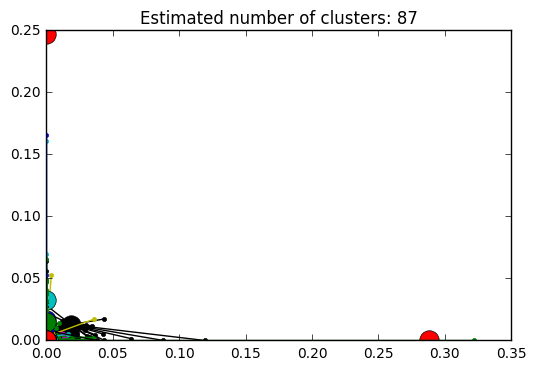

In [49]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = tfidf_array[cluster_centers_indices[k]]
    plt.plot(tfidf_array[class_members, 0], tfidf_array[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in tfidf_array[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()